In [1]:
import os
import pandas as pd
import re
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

import gensim
from gensim.utils import simple_preprocess
from gensim.models import ldamodel
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import nltk
import nltk.tag
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint

from scipy.sparse import coo_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import model_selection
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import data_prep
import LDA
import ngram
import linguistic_feature

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = data_prep.import_chi_review()
display(df[:5])

,Label,Rating,Ori_Review
0,1,1,Affinia Chicago is one of the worst hotels I h...
1,1,1,I recently stayed at the Affina Chicago hotel ...
2,1,1,I stayed at the Affina Chicago for my annivers...
3,1,1,If you are looking for a high end hotel on the...
4,1,1,I just returned from a long weekend in Chicago...


In [127]:
temp = df.copy()
temp.loc[temp['Label'] == -1, 'Label'] = 0
temp.to_csv('Chicago_Hotel_Reviews.csv')

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

In [4]:
df_train = data_prep.preprocess_ngram(df_train)
df_test = data_prep.preprocess_ngram(df_test)

In [5]:
unigrams, bigrams, trigrams, unigrams_dict, bigrams_dict, trigrams_dict = ngram.find_universal_ngrams(df_train['PP_Review'])

In [6]:
df_train['Ngram'] = df_train['Word_List'].apply(lambda x: ngram.find_ngrams(x, unigrams_dict, bigrams_dict, trigrams_dict))
df_test['Ngram'] = df_test['Word_List'].apply(lambda x: ngram.find_ngrams(x, unigrams_dict, bigrams_dict, trigrams_dict))
display(df_train[:3])
display(df_test[:3])

,Label,Rating,Ori_Review,Clean_Review,PP_Review,Word_List,Ngram
0,-1,1,"great bed, but when I first came in, I request...",great bed but when i first come in i request a...,great bed first come request lake view request...,"[great, bed, first, come, request, lake, view,...","[great, bed, first, come, request, lake, view,..."
1,1,1,Don't let the website fool you. I stayed at th...,do not let the website fool you i stay at the ...,let website fool amalfi last business trip pro...,"[let, website, fool, amalfi, last, business, t...","[let, website, amalfi, last, business, trip, p..."
2,-1,1,Just returned from a one night stay at the Kni...,just return from a one night stay at the knick...,return one night knickerbocker return come now...,"[return, one, night, knickerbocker, return, co...","[return, one, night, knickerbocker, return, co..."


,Label,Rating,Ori_Review,Clean_Review,PP_Review,Word_List,Ngram
0,1,5,My stay at the Hotel Monaco Chicago was amazin...,my stay at the hotel monaco chicago be amaze t...,monaco amaze staff polite well poise eager giv...,"[monaco, amaze, staff, polite, well, poise, ea...","[monaco, amaze, staff, polite, well, give, hel..."
1,1,1,"For the price, you would think this would be a...",for the price you would think this would be a ...,price think top quality nowhere close service ...,"[price, think, top, quality, nowhere, close, s...","[price, think, top, quality, close, service, c..."
2,-1,5,We just got back from 3 nights at the Sofitel....,we just get back from night at the sofitel we ...,get back night sofitel really nothing bad nega...,"[get, back, night, sofitel, really, nothing, b...","[get, back, night, sofitel, really, nothing, b..."


In [7]:
bigram_words = [' '.join(bigram) for bigram in bigrams]
trigram_words = [' '.join(trigram) for trigram in trigrams]
new_words = unigrams + bigram_words + trigram_words

In [8]:
df_train = data_prep.preprocess_ling_feature(df_train)
df_train = linguistic_feature.ling_feature(df_train)
df_test = data_prep.preprocess_ling_feature(df_test)
df_test = linguistic_feature.ling_feature(df_test)

In [9]:
word2ind = dict(zip(new_words, range(len(new_words))))

In [10]:
X_train, y_train = data_prep.df2matrix(df_train, word2ind)
X_test, y_test = data_prep.df2matrix(df_test, word2ind)

In [11]:
X_train_pos = X_train[X_train['Rating'] == 5]
y_train_pos = y_train[X_train['Rating'] == 5]
X_train_neg = X_train[X_train['Rating'] == 1]
y_train_neg = y_train[X_train['Rating'] == 1]

X_test_pos = X_test[X_test['Rating'] == 5]
y_test_pos = y_test[X_test['Rating'] == 5]
X_test_neg = X_test[X_test['Rating'] == 1]
y_test_neg = y_test[X_test['Rating'] == 1]

In [12]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [13]:
X_train_pos_std = StandardScaler().fit_transform(X_train_pos)
X_train_neg_std = StandardScaler().fit_transform(X_train_neg)
X_test_pos_std = StandardScaler().fit_transform(X_test_pos)
X_test_neg_std = StandardScaler().fit_transform(X_test_neg)

In [96]:
pca = PCA()
svm_model = SVC(random_state=0)
pipeline = Pipeline(steps=[('pca', pca), ('svm', svm_model)])
parameters = {'svm__C': [3, 4], 'pca__n_components': list(range(1, 1001, 50))}
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train_std, y_train)
print('Best Parameters: ', grid_search.best_params_)
print('Score', grid_search.best_score_)

Best Parameters:  {'pca__n_components': 201, 'svm__C': 3}
Score 0.85390625


In [106]:
pca = PCA(n_components=200)
svm_model = SVC(random_state=0, C=3)
svm_model.fit(X_train_std, y_train)
print('Test Overall Accuracy: ', "{:.1%}".format(svm_model.score(X_test_std, y_test)))
print('Test Positive Accuracy: ', "{:.1%}".format(svm_model.score(X_test_pos_std, y_test_pos)))
print('Test Negative Accuracy: ', "{:.1%}".format(svm_model.score(X_test_neg_std, y_test_neg)))

Test Overall Accuracy:  87.5%
Test Positive Accuracy:  84.1%
Test Negative Accuracy:  89.0%


In [109]:
rf_model = RandomForestClassifier(random_state=0)
parameters = {'n_estimators': [100, 300, 500],
              'criterion': ['gini', 'entropy'],
              'max_features': [5, 10, 20, None],
              'max_depth': [5, 10, 20, 50, 100, None],
              'max_samples': [100, 500, None]}
grid_search = GridSearchCV(rf_model, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('Best Parameters: ', grid_search.best_params_)
print('Score', grid_search.best_score_)

KeyboardInterrupt: 

In [98]:
rf_model = RandomForestClassifier(random_state=0, criterion='entropy', max_depth=50, max_features=10, n_estimators=500)
rf_model.fit(X_train, y_train)
print('Train Overall Accuracy: ', "{:.1%}".format(rf_model.score(X_train, y_train)))
print('Test Overall Accuracy: ', "{:.1%}".format(rf_model.score(X_test, y_test)))
print('Test Positive Accuracy: ', "{:.1%}".format(rf_model.score(X_test_pos, y_test_pos)))
print('Test Negative Accuracy: ', "{:.1%}".format(rf_model.score(X_test_neg, y_test_neg)))

Train Overall Accuracy:  100.0%
Test Overall Accuracy:  88.8%
Test Positive Accuracy:  89.2%
Test Negative Accuracy:  88.3%


In [105]:
np.argsort(rf_model.feature_importances_)

array([1057,  592,  806, ..., 1066, 1063, 1067], dtype=int64)

In [108]:
rf_model.feature_importances_[1067]

0.01762025039946237

In [35]:
y_train_xgb = y_train.copy()
y_train_xgb[y_train == -1] = 0
y_test_xgb = y_test.copy()
y_test_xgb[y_test == -1] = 0
y_test_pos_xgb = y_test_pos.copy()
y_test_pos_xgb[y_test_pos == -1] = 0
y_test_neg_xgb = y_test_neg.copy()
y_test_neg_xgb[y_test_neg == -1] = 0

In [112]:
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False)
parameters = {'n_estimators': [100, 300, 500],
             'max_depth': [10, 20, 50, 100, 500],
             'colsample_bytree': [0.1, 0.5, 1],
             'subsample': [0.1, 0.5, 1]}
grid_search = GridSearchCV(xgb_model, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train_xgb)
print('Best Parameters: ', grid_search.best_params_)
print('Score', grid_search.best_score_)

[02:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:39:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:40:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:45:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:45:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:45:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:45:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:47:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:47:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:48:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:50:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:50:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:51:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:53:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:54:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:54:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:55:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:56:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:56:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:56:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:56:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:58:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:58:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:58:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[02:59:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:59:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:01:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:03:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:03:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:08:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:08:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:08:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:08:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:09:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:10:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:10:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:12:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:12:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:14:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:16:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:16:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[03:18:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters:  {'colsample_bytree': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.5}
Score 0.83046875


In [37]:
xgb_model = XGBClassifier(random_state=0, use_label_encoder=False, max_depth=10, colsample_bytree=0.1, subsample=0.5)
xgb_model.fit(X_train, y_train_xgb)
print('Train Overall Accuracy: ', "{:.1%}".format(xgb_model.score(X_train, y_train_xgb)))
print('Test Overall Accuracy: ', "{:.1%}".format(xgb_model.score(X_test, y_test_xgb)))
print('Test Positive Accuracy: ', "{:.1%}".format(xgb_model.score(X_test_pos, y_test_pos_xgb)))
print('Test Negative Accuracy: ', "{:.1%}".format(xgb_model.score(X_test_neg, y_test_neg_xgb)))

[13:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Overall Accuracy:  99.8%
Test Overall Accuracy:  82.5%
Test Positive Accuracy:  81.5%
Test Negative Accuracy:  83.4%


In [47]:
xgb_model = XGBClassifier(random_state=0, 
                          use_label_encoder=False, 
                          max_depth=5, 
                          colsample_bytree=0.1, 
                          subsample=1, 
                          min_child_weight=1, 
                          learning_rate=0.1,
                          lamda=1,
                          alpha=2)
xgb_model.fit(X_train, y_train_xgb)
print('Train Overall Accuracy: ', "{:.1%}".format(xgb_model.score(X_train, y_train_xgb)))
print('Test Overall Accuracy: ', "{:.1%}".format(xgb_model.score(X_test, y_test_xgb)))
print('Test Positive Accuracy: ', "{:.1%}".format(xgb_model.score(X_test_pos, y_test_pos_xgb)))
print('Test Negative Accuracy: ', "{:.1%}".format(xgb_model.score(X_test_neg, y_test_neg_xgb)))

[14:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Overall Accuracy:  94.1%
Test Overall Accuracy:  81.6%
Test Positive Accuracy:  83.4%
Test Negative Accuracy:  79.8%


In [156]:
type(X_train)

pandas.core.frame.DataFrame

In [163]:
X_train_tf = X_train.values
y_train_tf = y_train.values
X_test_tf = X_test.values
y_test_tf = y_test.values

In [166]:
y_train_tf

array([-1,  1, -1, ..., -1, -1, -1], dtype=int64)

In [175]:
X_train_tf = tf.convert_to_tensor(X_train)
y_train_tf = tf.convert_to_tensor(y_train)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_tf = tf.convert_to_tensor(y_test)

In [191]:
y_train_tf

<tf.Tensor: shape=(1280,), dtype=int64, numpy=array([-1,  1, -1, ..., -1, -1, -1], dtype=int64)>

In [187]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def lr_scheduler(epoch):
    new_lr = 1 * 0.9 ** epoch
    print("Learning rate:", new_lr)
    return new_lr

nn_model = Sequential()
nn_model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
# nn_model.add(Dense(20, activation='relu'))
# nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(100, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(50, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(50, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(20, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(20, activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(loss='binary_crossentropy',
#                  optimizer='adam',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 metrics=['accuracy'])
nn_model.fit(X_train_tf,
             y_train_tf,
             epochs=5,
             batch_size=32,
             shuffle=True,
             validation_data=(X_test_tf, y_test_tf))

Epoch 1/5
40/40 [==============================] - 0s 5ms/step - loss: 8.2732 - accuracy: 0.2914 - val_loss: 0.4912 - val_accuracy: 0.0000e+00
Epoch 2/5
40/40 [==============================] - 0s 2ms/step - loss: 6.9360 - accuracy: 0.3055 - val_loss: 0.5137 - val_accuracy: 0.0000e+00
Epoch 3/5
40/40 [==============================] - 0s 2ms/step - loss: 6.3873 - accuracy: 0.2977 - val_loss: 0.5603 - val_accuracy: 0.0000e+00
Epoch 4/5
40/40 [==============================] - 0s 2ms/step - loss: 5.6248 - accuracy: 0.2727 - val_loss: 0.6773 - val_accuracy: 0.0594
Epoch 5/5
40/40 [==============================] - 0s 2ms/step - loss: 4.7155 - accuracy: 0.2734 - val_loss: 0.8209 - val_accuracy: 0.4563


In [167]:
nn_model.evaluate(X_test_tf, y_test_tf)

10/10 [==============================] - 0s 802us/step - loss: -2.0434 - accuracy: 0.0000e+00


[-2.0433764457702637, 0.0]

In [22]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [23]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

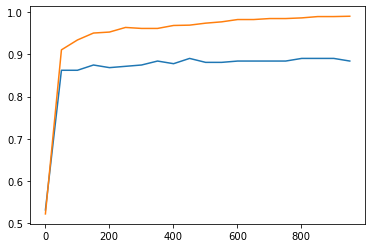

In [24]:
pca_components = []
pca_train_accuracies = []
pca_test_accuracies = []
pca_f1_scores = []
for k in range(1, 1001, 50):
    svm_model = SVC(random_state=0)
    svm_model.fit(X_train_pca[:, :k], y_train)
    pca_components.append(k)
    pca_train_accuracies.append(svm_model.score(X_train_pca[:, :k], y_train))
    pca_test_accuracies.append(svm_model.score(X_test_pca[:, :k], y_test))
    pca_f1_scores.append(f1_score(y_test, svm_model.predict(X_test_pca[:, :k])))
plt.figure()
plt.plot(pca_components, pca_test_accuracies)
plt.plot(pca_components, pca_train_accuracies)

In [25]:
print('# of components: ', pca_components[np.where(pca_test_accuracies == max(pca_test_accuracies))[0][0]])
print(max(pca_test_accuracies))

# of components:  451
0.890625


651

In [90]:
documents = df_train['Ngram'].tolist()
documents_truth = df_train[df_train['Label'] == -1]['Ngram'].tolist()
documents_fake = df_train[df_train['Label'] == 1]['Ngram'].tolist()

In [91]:
id2word = corpora.Dictionary(documents)
corpus_truth = [id2word.doc2bow(text) for text in documents_truth]
corpus_fake = [id2word.doc2bow(text) for text in documents_fake]

In [92]:
lda_model_truth = gensim.models.LdaModel(corpus=corpus_truth, id2word=id2word, num_topics=1, passes=1, random_state=0, alpha=1, eta=1)
lda_model_fake = gensim.models.LdaModel(corpus=corpus_fake, id2word=id2word, num_topics=1, passes=1, random_state=0, alpha=1, eta=1)

In [94]:
pprint(lda_model_truth.print_topics(num_words=20))
pprint(lda_model_fake.print_topics(num_words=20))

[(0,
  '0.012*"great" + 0.011*"get" + 0.010*"night" + 0.010*"staff" + '
  '0.009*"service" + 0.008*"bed" + 0.008*"one" + 0.007*"good" + '
  '0.007*"location" + 0.007*"go" + 0.007*"u" + 0.007*"check" + 0.007*"time" + '
  '0.006*"nice" + 0.006*"call" + 0.006*"bathroom" + 0.006*"day" + 0.006*"make" '
  '+ 0.005*"desk" + 0.005*"clean"')]
[(0,
  '0.012*"get" + 0.010*"service" + 0.009*"staff" + 0.009*"go" + 0.008*"like" + '
  '0.008*"time" + 0.008*"one" + 0.008*"make" + 0.008*"great" + 0.007*"check" + '
  '0.007*"bed" + 0.007*"night" + 0.006*"look" + 0.006*"clean" + 0.006*"place" '
  '+ 0.006*"experience" + 0.006*"desk" + 0.005*"even" + 0.005*"take" + '
  '0.005*"find"')]


In [20]:
lda_model_pos = gensim.models.LdaModel(corpus=corpus_pos, id2word=id2word, num_topics=2, passes=1, random_state=0, alpha=1, eta=1)
lda_model_neg = gensim.models.LdaModel(corpus=corpus_neg, id2word=id2word, num_topics=2, passes=1, random_state=0, alpha=1, eta=1)

In [21]:
pprint(lda_model_pos.print_topics(num_words=10))
pprint(lda_model_neg.print_topics(num_words=10))

[(0,
  '0.022*"great" + 0.010*"staff" + 0.010*"night" + 0.008*"get" + '
  '0.008*"service" + 0.008*"clean" + 0.008*"bed" + 0.008*"one" + '
  '0.007*"location" + 0.007*"like"'),
 (1,
  '0.014*"staff" + 0.012*"great" + 0.010*"service" + 0.008*"location" + '
  '0.008*"nice" + 0.008*"get" + 0.008*"time" + 0.008*"go" + 0.008*"bed" + '
  '0.007*"recommend"')]
[(0,
  '0.013*"get" + 0.011*"one" + 0.011*"night" + 0.009*"check" + 0.008*"desk" + '
  '0.008*"go" + 0.008*"u" + 0.008*"service" + 0.007*"bed" + 0.007*"like"'),
 (1,
  '0.013*"get" + 0.011*"service" + 0.011*"go" + 0.008*"staff" + 0.008*"time" + '
  '0.008*"call" + 0.008*"look" + 0.007*"make" + 0.007*"take" + 0.007*"check"')]


In [60]:
k = []
coherance = []
for num_topics in range(2, 31):
    lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=1, random_state=0, alpha=1, eta=1)
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=documents, coherence='c_v')
    cm.get_coherence()
    k.append(num_topics)
    coherance.append(cm.get_coherence())

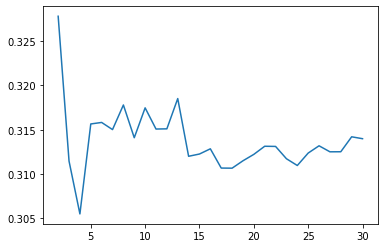

In [61]:
plt.plot(k, coherance)

In [54]:
alpha = []
beta = []
coherance_ab = []
for a in [0.1, 0.5, 1, 5, 10]:
    for b in [0.1, 0.5, 1, 5, 10]:
        lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=5, random_state=0, alpha=a, eta=b)
        cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_word, coherence='c_v')
        cm.get_coherence()
        alpha.append(a)
        beta.append(b)
        coherance_ab.append(cm.get_coherence())

In [74]:
coh = np.array(coherance_ab).reshape([5, 5])
print(coh)

[[0.35077943 0.35077943 0.35800504 0.3364428  0.31868536]
 [0.3533616  0.3533616  0.35800504 0.3364428  0.31868536]
 [0.3533616  0.3533616  0.36238121 0.3364428  0.3364428 ]
 [0.30391318 0.30391318 0.30391318 0.31874846 0.30837667]
 [0.29490365 0.29490365 0.29490365 0.29040401 0.29040401]]


In [71]:
print('Optimal Alpha: ', alpha[np.where(coherance_ab == max(coherance_ab))[0][0]])
print('Optimal Beta: ', beta[np.where(coherance_ab == max(coherance_ab))[0][0]])

Optimal Alpha:  1
Optimal Beta:  1


In [75]:
best_alpha = 1
best_beta = 1
best_k = 2

In [76]:
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=best_k, passes=10, random_state=0, alpha=best_alpha, eta=best_beta)

In [62]:
pprint(lda_model.print_topics(num_words=10))

[(18,
  '0.026*"room" + 0.017*"stay" + 0.009*"get" + 0.007*"great" + 0.006*"one" + '
  '0.006*"good" + 0.006*"service" + 0.006*"go" + 0.005*"like" + 0.005*"staff"'),
 (13,
  '0.030*"room" + 0.014*"stay" + 0.008*"get" + 0.007*"go" + 0.006*"staff" + '
  '0.006*"time" + 0.006*"great" + 0.006*"night" + 0.006*"service" + '
  '0.005*"bed"'),
 (2,
  '0.024*"room" + 0.016*"stay" + 0.010*"get" + 0.008*"service" + 0.006*"one" + '
  '0.006*"good" + 0.006*"great" + 0.006*"like" + 0.005*"make" + 0.005*"staff"'),
 (16,
  '0.020*"room" + 0.014*"stay" + 0.009*"get" + 0.008*"staff" + 0.006*"one" + '
  '0.006*"night" + 0.005*"make" + 0.005*"check" + 0.005*"go" + '
  '0.005*"location"'),
 (29,
  '0.022*"room" + 0.015*"stay" + 0.009*"staff" + 0.008*"get" + 0.008*"great" + '
  '0.006*"service" + 0.005*"u" + 0.005*"even" + 0.005*"like" + 0.005*"bed"'),
 (5,
  '0.030*"room" + 0.019*"stay" + 0.008*"get" + 0.007*"staff" + 0.006*"one" + '
  '0.006*"service" + 0.006*"check" + 0.006*"great" + 0.005*"location" + '